# Time Series Analysis and Forecasting of Household Energy Usage
## Summary and Objective
This project consists of analyzing the household energy usage and building different types of forecasting models to predict future usage. It is important to know the amount of household energy usage to strategically estasblish and adopt energy saving strategies. Energy saving strategies will overall reduce energy usage and lead to saving money. 

### Objective
The purpose of this project is to understand the amount of energy used over 2 years, find usage patterns, and select best forecasting model.

### Data Description
This data collected in San Jose using smart meters. Data consists of 8 columns:
    
    TYPE - This is an information column. The value is 'Electric usage' for all the observations.
    DATE - Date of electric consumption. There is no timestamp in this field.
    START TIME - Start time of the consumption.
    END TIME - End time of the consumption
    USAGE - Consumption in kWh
    UNITS - This column denotes measurement unit. It is kWh for all the observations.
    COST - Cost of consumption in $.
    NOTES
    
    The data can be accessed here: https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data

### Methods Used and Exploratory Analysis
The data is prepared by deleting irrelevant columns and checked for any missing values. The column of concentration is USAGE. The data is converted into time series by setting the index to datetime and frequency is changed to daily. Primarily, USAGE and COST columns are plotted to analyze their daily, monthly, and quarterly relationship. Furthermore, USAGE trend is inspected for trend/autocorellation, heteroscedasticity, and seasonality.

Next step requires to transform the USAGE to a stationary data. Three methods used to achieve the transformation include decomposition method, log transform, and differencing. Sequence plotting and ADF test is used to evaluate stationarity to select the data for forecasting. Note: Not every forecasting model will require stationary data to be used. ACF and PACF are plotted to find the orders of AR and MA.

The data is split into train and test subsets. Train subset is used fit into the four forecating models: including two ARIMA models, Triple Exponential Smoothing model, and Facebook Prophet model. The next 10 dates are predicted using each model and compared to the test subset with corresponding dates. The models are evaluated using sequence plotting and mean squared error.  

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Libraries for Forecasting
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pmd
from prophet import Prophet

#ADF and Stationarity Decomposition
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#Metrics
from sklearn.metrics import mean_squared_error as mse

plotsize = (13, 5)

In [2]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import data
energy_data=pd.read_excel("D202.xlsx")

In [4]:
#Get a preliminary understanding of the data
energy_data.info()
energy_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   TYPE        70368 non-null  object        
 1   DATE        70368 non-null  datetime64[ns]
 2   START TIME  70368 non-null  object        
 3   END TIME    70368 non-null  object        
 4   USAGE       70368 non-null  float64       
 5   UNITS       70368 non-null  object        
 6   COST        70368 non-null  float64       
 7   NOTES       0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 4.3+ MB


,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,2016-10-22,00:00:00,00:14:00,0.01,kWh,0.0,NaN
1,Electric usage,2016-10-22,00:15:00,00:29:00,0.01,kWh,0.0,NaN
2,Electric usage,2016-10-22,00:30:00,00:44:00,0.01,kWh,0.0,NaN
3,Electric usage,2016-10-22,00:45:00,00:59:00,0.01,kWh,0.0,NaN
4,Electric usage,2016-10-22,01:00:00,01:14:00,0.01,kWh,0.0,NaN


DATE column is already datetime object, so, no need to transform it. 

In [5]:
# Columns TYPE, NOTES, and UNITS does not provide any information, therefore will be deleted.
# Column END TIME is not needed because 'START TIME' column indicates that data is recorded in 15 minute interval.
energy_data.drop(columns=['TYPE','NOTES', 'UNITS', 'END TIME'], inplace=True)

In [6]:
#Transform data into time series by setting index to 'DATE' column
energy_data.set_index('DATE', inplace=True)

In [7]:
#Confirm the transformation
energy_data

,START TIME,USAGE,COST
DATE,,,
2016-10-22,00:00:00,0.01,0.00
2016-10-22,00:15:00,0.01,0.00
2016-10-22,00:30:00,0.01,0.00
2016-10-22,00:45:00,0.01,0.00
2016-10-22,01:00:00,0.01,0.00
...,...,...,...
2018-10-24,22:45:00,0.02,0.00
2018-10-24,23:00:00,0.03,0.01
2018-10-24,23:15:00,0.03,0.01


In [8]:
#Check if any missing data is present
energy_data.isnull().sum()

START TIME    0
USAGE         0
COST          0
dtype: int64

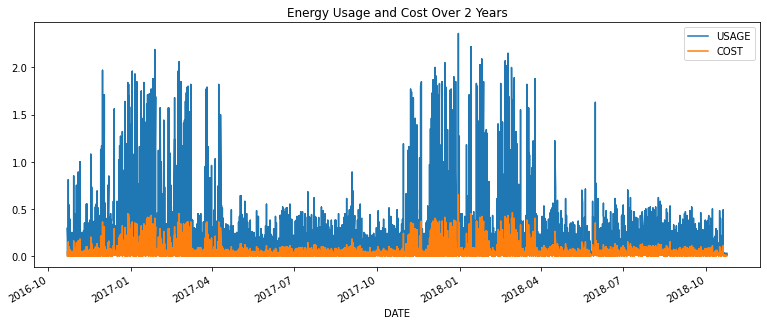

In [9]:
#Plotting USAGE and COST 
energy_data.plot(figsize=plotsize)
plt.title("Energy Usage and Cost Over 2 Years")
plt.show()

Energy cost and usage show a similar pattern. As energy usage increases, cost increases as well.

In [10]:
# Resample and analyzing total cost and usage daily, monthly, and quarterly
daily_data=energy_data.resample('D').sum()
month_data=daily_data.resample('M').sum()
quarterly_data=daily_data.resample('Q').sum()

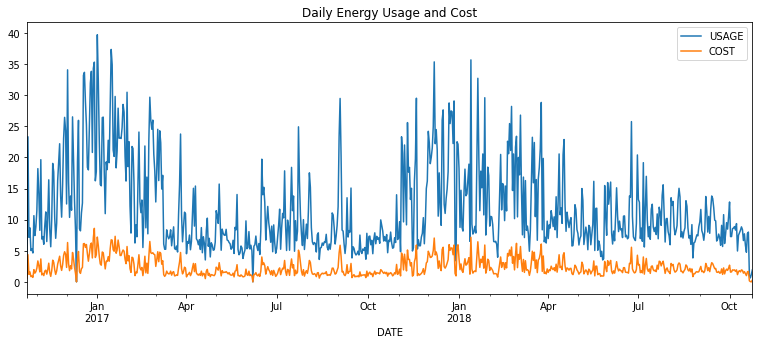

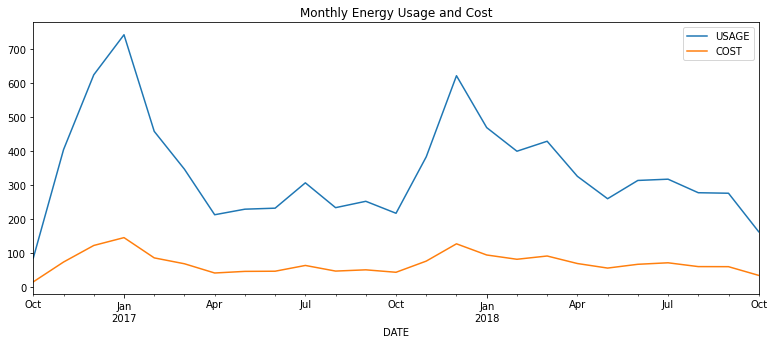

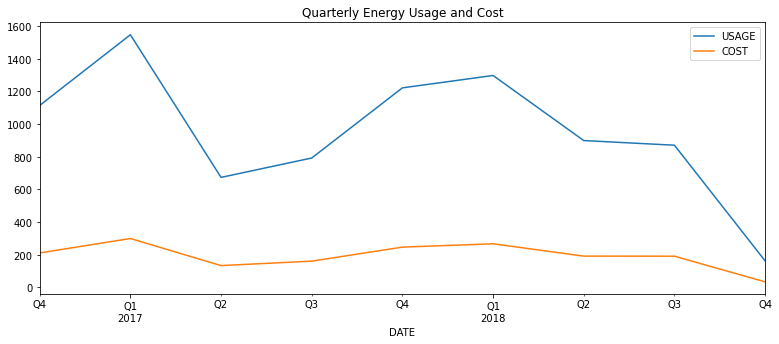

In [11]:
#Plot daily, monthly, and quarterly samples
daily_data.plot(figsize=plotsize, title='Daily Energy Usage and Cost')
month_data.plot(figsize=plotsize, title='Monthly Energy Usage and Cost')
quarterly_data.plot(figsize=plotsize, title='Quarterly Energy Usage and Cost')
plt.show()

- Daily, Monthly, and Quarterly plots show a similar pattern. Usage and cost peaks during Q1 and begins to decrease in Q2. 

- Trend/Autocorrelation, Heteroscedasticity, and Seasonlaity are indicated.

#### Using daily data for further analysis.

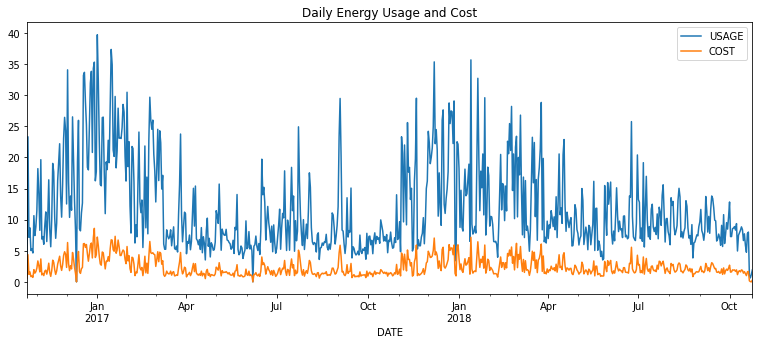

In [12]:
#Plot daily_data again to dive deeper in analysis
daily_data.plot(figsize=plotsize, title='Daily Energy Usage and Cost')
plt.show()

Graph does indicate existence of trend/autocorrelation, heterosedasticity, and seasonality. To use forcasting algorithms as ARIMA, the data needs have constant variance, no seanality, and no trend, ultimately meaning that data needs to become stationary. To achieve this, decomposition method, log transform, and differencing are used.

Further analyze stationary of the data by plotting its distribution to check its variance. Normal distribution will indicate data having constant variance and Augmented Dickey-Fuller Test is used to confirm it.

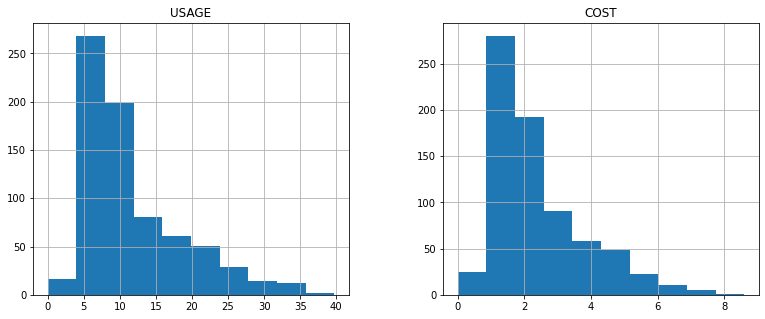

In [13]:
# Graph distribution of daily data
daily_data.hist(figsize=plotsize)
plt.show()

The distribution shows the both usage and cost skew to the right and are not normally distributed.

#### Using ADF test: 
    
    Construct Hypothesis
        Null Hypothesis: Data is nonstationary
        Alternative Hyposthesis: Data is stationary
    
    Confidence interval: Choosing 95%
    
    Evaluating results:
    More negative the ADF value, the better stationary is indicated. The p-value output below 0.05 will also indicate stationarity. 

In [14]:
#Resusable function for ADF test
def adf_test(data, column):
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data)
    print(column,": ","\nADF value: ", adf,"\nP Value: ",pvalue)

In [15]:
#ADF Test for Usage
adf_test(daily_data.USAGE, 'Usage')

Usage :  
ADF value:  -2.423278437269916 
P Value:  0.1352737363577925


In [16]:
#ADF test for Cost
adf_test(daily_data.COST, 'Cost')

Cost :  
ADF value:  -2.63154696125422 
P Value:  0.08665084537270468


ADF test statistic value and p-value indicate nonstationary of the data. Null hypothesis is accepted.

### Next step: 
#### Use methods to transform nonstationary to stationary data.
1. Stationarity using decomposition method
2. Removing changing variance using log transform
3. Using differencing method

#### Check Autocorellation 
1. Plot ACF
2. Plot PACF

#### Using 'USAGE' column for further analysis

##### 1. Decomposition Method

In [17]:
#Decomposing the non-stationary data to achieve the residuals
daily_decom = seasonal_decompose(x=daily_data.USAGE, model='additive')
usage_trend=daily_decom.trend.dropna()
usage_seasonal=daily_decom.seasonal.dropna()
usage_resid=daily_decom.resid.dropna()

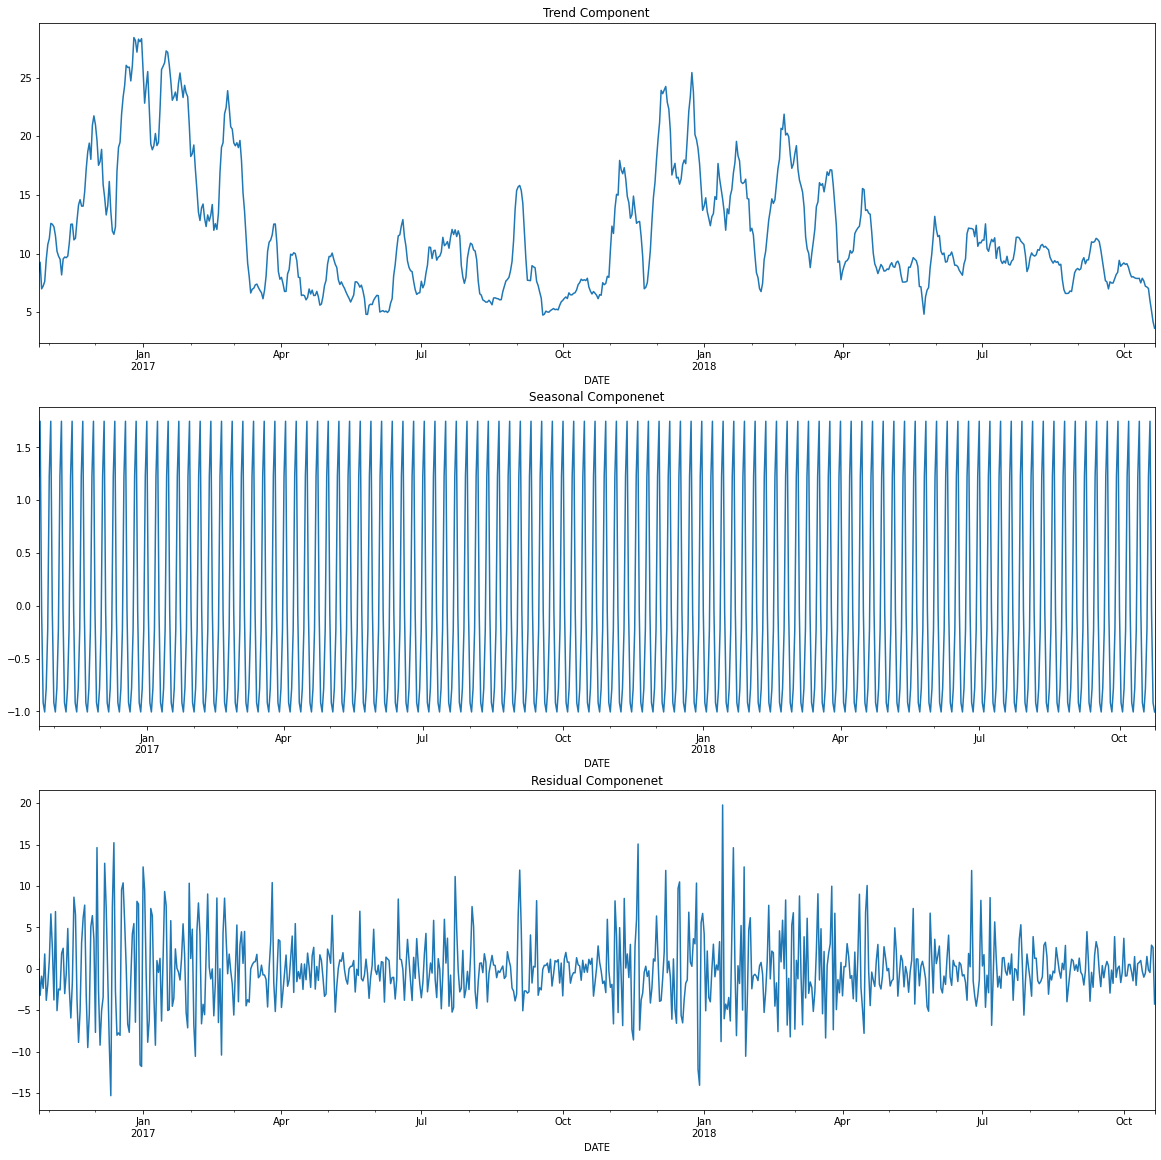

In [18]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
usage_trend.plot(title='Trend Component')
plt.subplot(3,1,2)
usage_seasonal.plot(title='Seasonal Componenet')
plt.subplot(3,1,3)
usage_resid.plot(title='Residual Componenet')
plt.show()

Decomposing the data generated a more stationary data, as seen by inspecting the plot of the residual component.
ADF test is used to confirm stationarity. 

In [19]:
#Run an ADF test for Residual Component
adf_test(usage_resid, "Residual Component")

Residual Component :  
ADF value:  -11.865349688588099 
P Value:  6.695796252006038e-22


As confirmed by ADF test, residal component indicates stationarity of the data. The p-value is much lower than 0.05.

##### 2. Log Transform 

In [20]:
#Transform data using log to decrease variance
usage_log=np.log1p(daily_data.USAGE)

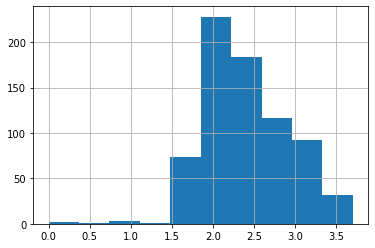

In [21]:
usage_log.hist()
plt.show()

<AxesSubplot:xlabel='DATE'>

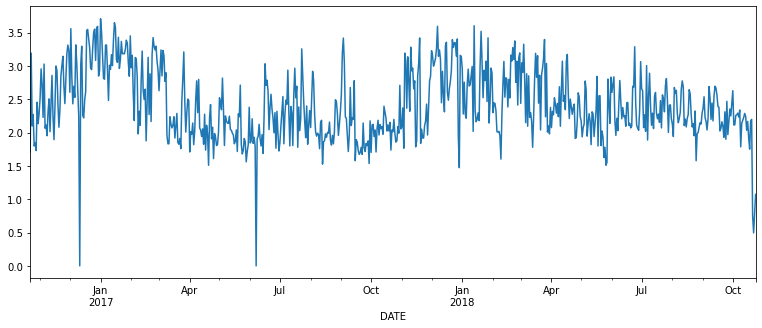

In [22]:
# Plot the log transformed data
usage_log.plot(figsize=plotsize)

In [23]:
#Running adf test on log data
adf_test(usage_log, "Log Data")

Log Data :  
ADF value:  -4.302558161367392 
P Value:  0.0004397030018897998


Log does worse at transforming the data into stationary series as seen on the plot. Log data ADF values is worse than residual component ADF values.

##### 3. Differencing Method

In [24]:
diff_data=np.array(daily_data["USAGE"].copy())

In [25]:
diff=diff_data[:-1]-diff_data[1:]

In [26]:
usage_diff=pd.DataFrame({'oiginal':diff_data[:-1],'shift':diff_data[1:], 'Differenced':diff})

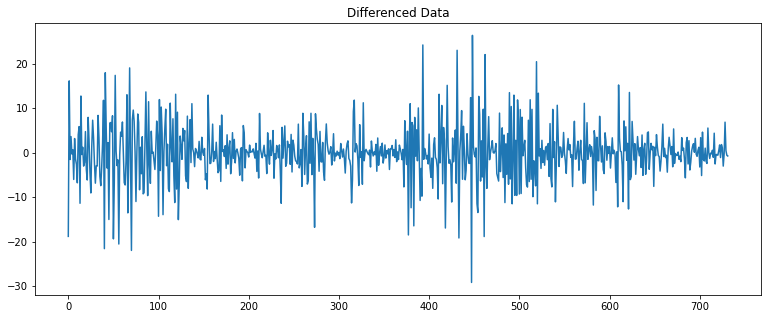

In [27]:
usage_diff.Differenced.plot(figsize=plotsize, title='Differenced Data')
plt.show()

In [28]:
adf_test(usage_diff.Differenced, "Differenced")

Differenced :  
ADF value:  -10.370895608539834 
P Value:  2.2656194053142376e-18


Differenced data looks much better than log data. ADF values look great as well. Because decomposition method performs a bit better than differencing method, residual data is kept for forcasting.

##### Checking for Autocorellation

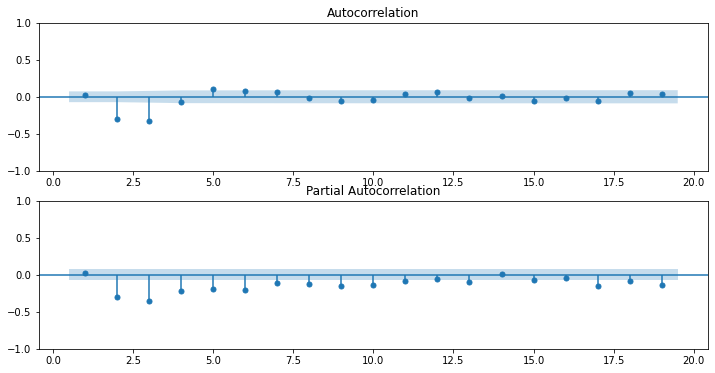

In [29]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(usage_resid, ax=ax[0], lags=range(1,20), alpha=0.05)
ax[1] = plot_pacf(usage_resid, ax=ax[1], lags=range(1,20), alpha=0.05)

 PACF plot indicates AR(p) order to be 3 and ACF plot indicates MA(q) order to be 3. Since, statinary data is used, the value of d is 0.

## Forecasting
1. ARIMA Method
    - ARIMA Model
    - Auto Arima Model
2. Triple Exponential Model
3. Facebook Prophet Model

#### 1. ARIMA Method
For ARIMA, we will be using the residuals of the daily data as the stationary data.

In [30]:
#Dataframe to hold MSE values for each model for evaluation
MSE_data=pd.DataFrame(index=['MSE'])

In [31]:
#Create a function to graph and obtain MSE of the models for evaluation
def plot_f(true, preds,model=False, model_name=False):
    #plt.figure(figsize=plotsize)
    true.plot(figsize=plotsize, label='True')
    preds.plot(figsize=plotsize, label='Predicted')
    plt.title(model_name+ " Performance")
    MSE=mse(true, preds)
    MSE_data[model_name]=MSE    
    plt.xlabel("DATE")
    plt.legend()
    print('MSE: ',MSE)

In [32]:
#Split data into train and test sets
arima_train_data=usage_resid[:-10]
arima_test_data=usage_resid[-10:]

In [33]:
#Arima Model
model_arima=ARIMA(arima_train_data, order=(3,0,3), trend='n').fit()
model_arima.params

ar.L1     -0.006716
ar.L2      0.313963
ar.L3     -0.513387
ma.L1     -0.444128
ma.L2     -0.891573
ma.L3      0.335905
sigma2    10.783111
dtype: float64

In [34]:
#Forecast the next number of values in same lenght of the test subset
forecasted_arima=model_arima.forecast(len(arima_test_data))

MSE:  3.648128089155955


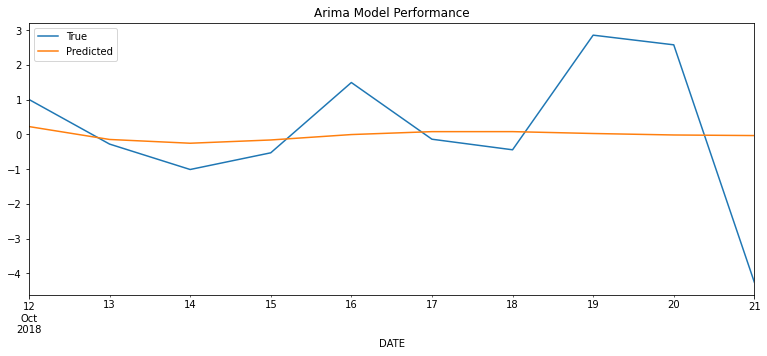

In [35]:
#Plot test vs. predicted values
plot_f(arima_test_data, forecasted_arima, model_arima, model_name="Arima Model")

In [36]:
#Auto Arima Model

#Finding the best MA, AR, and I orders 
auto_arima = pmd.auto_arima(arima_train_data, start_p=1, start_q=1, start_d=1,
                           max_p=3, max_q=3, max_d=3,
                           seasonal=False, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4128.936, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4130.812, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4132.581, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4132.266, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4065.887, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3972.937, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3974.936, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.251 seconds


Auto Arima indicates best model has 3,0,0 for AR, I, and MA, respectively. 

In [37]:
model_auto_arima=ARIMA(arima_train_data, order=(3,0,0), trend='n').fit()

In [38]:
preds=model_auto_arima.forecast(len(arima_test_data))

MSE:  3.6909088103631005


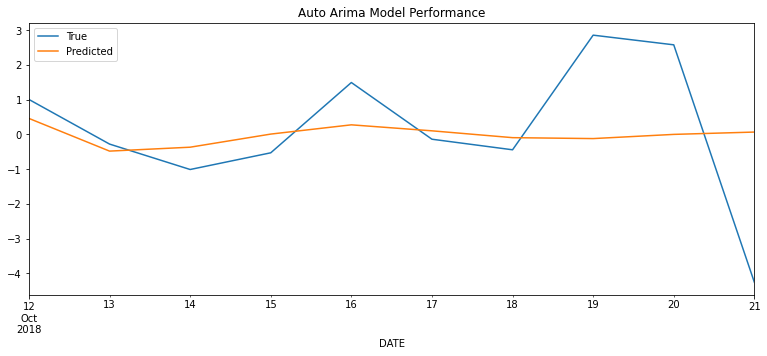

In [39]:
plot_f(arima_test_data, preds, model_auto_arima, model_name="Auto Arima Model")

#### 2. Triple Exponential Smoothing
Using non-stationary data for Triple Exponenetial Smoothing as this model is great for predicting values if trend and seasonality is indicated. 

<AxesSubplot:xlabel='DATE'>

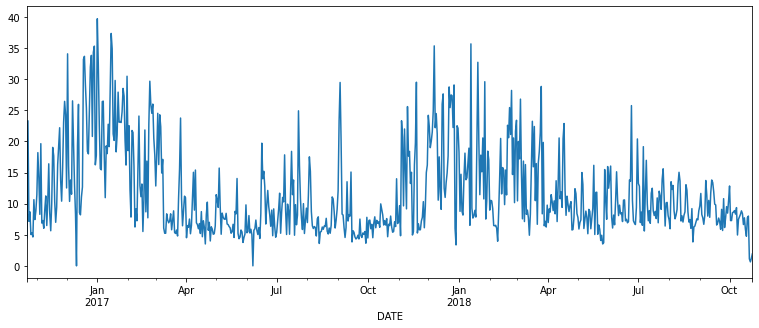

In [40]:
daily_data.USAGE.plot(figsize=plotsize)
#trend and seasonality exists, thefore will use Triple exponential smoothing 

In [41]:
#Using daily_data.USAGE and splitting into train and test subsets
train_data=daily_data.USAGE[:-10]
test_data=daily_data.USAGE[-10:]

In [42]:
# Train the model 
model_triple_exp = ExponentialSmoothing(train_data,
                              trend="additive",
                              seasonal="additive").fit(optimized=True)
preds = model_triple_exp.forecast(len(test_data))

MSE:  17.709763863236446


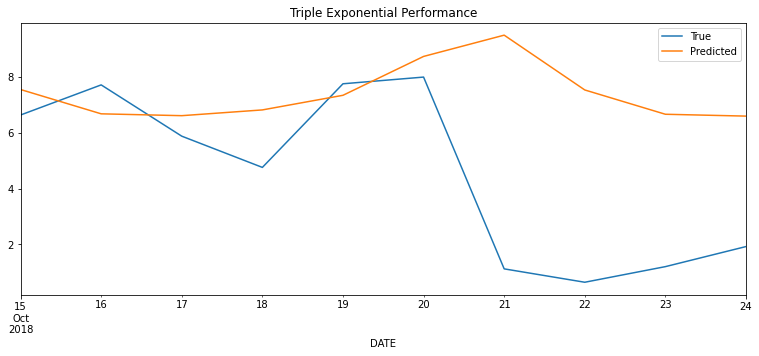

In [43]:
plot_f(test_data, preds, model_triple_exp, model_name="Triple Exponential")

#### 3. Facebook Prophet Model

In [44]:
#Prophet needs to have ds and y column
prophet_data=pd.DataFrame()
prophet_data['ds']=usage_resid.index
prophet_data['y']=usage_resid.values

In [45]:
train_prophet=prophet_data[:-10]
test_prophet=prophet_data[-10:]

In [46]:
# Will use usage_resid data
model_prophet=Prophet()
model_prophet.fit(train_prophet)

12:00:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
#Create blank data frame 
future = model_prophet.make_future_dataframe(periods=10)
forecast = model_prophet.predict(future)

In [48]:
test_prophet.set_index('ds', inplace=True)

In [49]:
#Predict the next 10 values and plot
preds=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-10:]

In [50]:
preds.set_index('ds', inplace=True)

MSE:  3.8812447392673


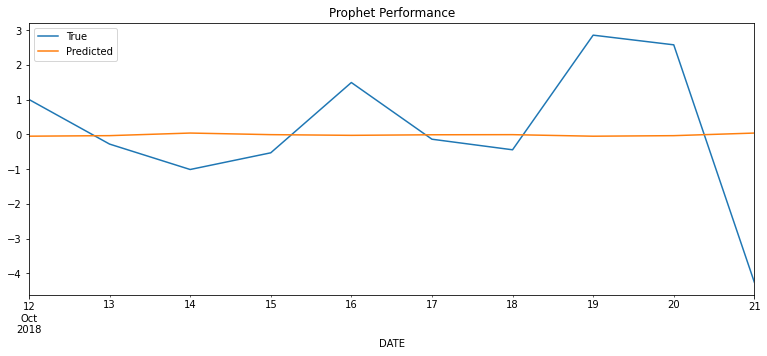

In [51]:
plot_f(test_prophet.y, preds.yhat, model_name="Prophet")

In [52]:
MSE_data=MSE_data.T

In [53]:
#Print MSE values of each model
MSE_data

,MSE
Arima Model,3.648128
Auto Arima Model,3.690909
Triple Exponential,17.709764
Prophet,3.881245


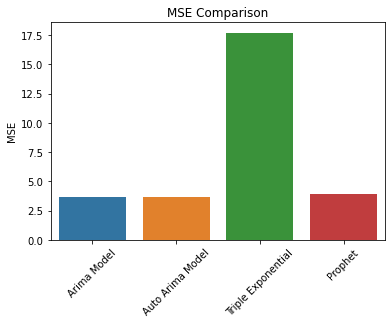

In [54]:
#Comparing mean squred error values of 4 models
sns.barplot(MSE_data.index, MSE_data['MSE'])
plt.xticks(rotation=45)
plt.title("MSE Comparison")
plt.show()

Lower the MSE value, the better the model performs. The MSE Comparison graph indicates that Arima, Auto Arima, and Prophet model performs in similarly, but Triple Exponential model perfroms worse as its MSE number is 4 times as much.

## Results

### Summary of the Models Used and Best Model
Total of four models are trained and analyzed using sequence plotting and MSE value. 

    Model 1: ARIMA model with order (3,0,3) as indicated by ACF and PACF plot is trained using stationary data. 
    Model 2: ARIMA model with order (3,0,0) resulted from auto arima module from import pmdarima library is trained using stationray data.
    Model 3. Triple Exponential Smoothing treated as additive and trained using non-stationary data. This model is used becaues data showed both trend and seasonality.
    Model 4. Prophet model trained using stationary data.
    
    Best Model: Arima, Auto Arima, and Prophet model were all similar in performance, but Arima model did perform a little better based on its MSE value. However, Triple Exponential captures the pattern of the test data better compared to other models even though its MSE value is much higher.
    

### Key Findings and Insight
 - The pattern of usage and energy cost follow a similar pattern, mean that when one increases the other increses as well. 
 - The energy usage peaks during months of January and drops to minimum during December. Further analysis can be conducted to understand the reason and provide insights on improvements to prevent over usage. 
 - The usage data contains both trend/autocorrelation, heteroscedasticity, and seaonality. These components are decomposed to obtain the residuals as the stationary data.
 - Arima model is best in performance based on MSE value but Triple Exponential is better at capturing the pattern of the test data.

### Recommendation/Next Steps:
 - The current project analyzed the data as a daily frequency, however, the original data was collected in fifteen minute intervals. This data can be analyzed to really undertand the hourly usage in different times of the day. This will provide more detail on customer activity. 
 - Current project concentrated on univarate analysis and forecasting, but multivarate analysis can be done to include multiple factors during forecasting. 
 - The current data ranges over two years but having data that ranges for multiple years can be better to train a forecasting model.
 - Using more sophisticated forecasting models or making the current models more complex (without overdifferencing and overfitting) can lead to better performance. 
